In [1]:
import Flux
using Flux.Tracker, Statistics, DelimitedFiles
using Flux.Tracker: Params, gradient, update!
using Flux: gpu, Dense, BatchNorm, relu, Chain, ADAM, RMSProp, Descent, params, throttle, Dropout, @epochs, testmode!

using Base.Iterators: repeated

using DataFrames, DataFramesMeta, ExcelFiles, MLDataUtils, HDF5, ProgressMeter, Plots, LinearAlgebra, NNlib
pyplot() # pyplot backend

using BSON: @save, @load

#using BenchmarkTools

# DATA IMPORT

In [2]:
X_columns = h5read("./data/DataSet.hdf5", "X_columns")

X_entropy_train = h5read("./data/DataSet.hdf5", "X_entropy_train")
X_entropy_train_sc = h5read("./data/DataSet.hdf5", "X_entropy_train_sc")

X_entropy_valid = h5read("./data/DataSet.hdf5", "X_entropy_valid")
X_entropy_valid_sc = h5read("./data/DataSet.hdf5", "X_entropy_valid_sc")

X_entropy_test = h5read("./data/DataSet.hdf5", "X_entropy_test")
X_entropy_test_sc = h5read("./data/DataSet.hdf5", "X_entropy_test_sc")

X_entropy_tv = [X_entropy_train X_entropy_valid]
X_entropy_sc_tv = [X_entropy_train_sc X_entropy_valid_sc]

X_tv = h5read("./data/DataSet.hdf5", "X_tv")
X_tv_sc = h5read("./data/DataSet.hdf5", "X_tv_sc")
y_tv = h5read("./data/DataSet.hdf5", "y_tv")

X_train = h5read("./data/DataSet.hdf5", "X_train")
X_train_sc = h5read("./data/DataSet.hdf5", "X_train_sc")
y_train = h5read("./data/DataSet.hdf5", "y_train")

X_valid = h5read("./data/DataSet.hdf5", "X_valid")
X_valid_sc = h5read("./data/DataSet.hdf5", "X_valid_sc")
y_valid = h5read("./data/DataSet.hdf5", "y_valid")

X_test = h5read("./data/DataSet.hdf5", "X_test")
X_test_sc = h5read("./data/DataSet.hdf5", "X_test_sc")
y_test = h5read("./data/DataSet.hdf5", "y_test")

X_scaler_mean = h5read("./data/DataSet.hdf5", "X_scaler_mean")
X_scaler_var = h5read("./data/DataSet.hdf5", "X_scaler_var")

X_raman_train = Float32.(h5read("./data/NKAS_DataSet.hdf5","X_raman_train"))
y_raman_train = Float32.((h5read("./data/NKAS_DataSet.hdf5","y_raman_train")))
X_raman_valid = Float32.(h5read("./data/NKAS_DataSet.hdf5","X_raman_test"))
y_raman_valid = Float32.((h5read("./data/NKAS_DataSet.hdf5","y_raman_test")))

println("loaded")
println("\nFeatures in X_ arrays are")
println(X_columns)
println("\nShape of X train and valid is")
println(size(X_tv))

print("Size of Raman datasets")
print(size(X_raman_train))
print(size(y_raman_train))
print(size(X_raman_valid))
print(size(y_raman_valid))

loaded

Features in X_ arrays are
["sio2", "al2o3", "na2o", "k2o", "nbot", "ifsm", "ifst", "ap", "b", "T", "Sc", "tg", "ScT"]

Shape of X train and valid is
(13, 1145)
Size of Raman datasets(4, 31)(850, 31)(4, 14)(850, 14)

In [3]:
function prepare_datas(X_,y_)
    
    y = reshape(y_[:],1,length(y_))
    
    x = X_[1:4,:]
    ap = reshape(X_[8,:],1,size(X_,2))
    b = reshape(X_[9,:],1,size(X_,2))
    T = reshape(X_[10,:],1,size(X_,2))
    #be = reshape(X_[11,:],1,size(X_,2))
    sc = reshape(X_[11,:],1,size(X_,2))
    tg = reshape(X_[12,:],1,size(X_,2))
    return Float32.(x), Float32.(y), Float32.(T), Float32.(ap), Float32.(b), Float32.(sc), Float32.(tg)
end

function gkfolds(X_, y_, idx_label; k = 5)

    dd = kfolds(shuffleobs(unique(X_[idx_label,:])), k = k);
    
    out = []
    
    for j = 1:k
        train_lab, vald_lab = dd[j]
        train_idx = Int64[]
        valid_idx = Int64[]

        for i = 1:size(X_,2)
            if findall(X_[idx_label,i] .== train_lab) != []
                push!(train_idx, i)
            else
                push!(valid_idx, i)
            end
        end
        
        push!(out,((X_[:,train_idx],y_[train_idx]),(X_[:,valid_idx],y_[valid_idx])))
        
    end
    
    return out
end


gkfolds (generic function with 1 method)

In [4]:
nb_folds = 5
folds = gkfolds(X_train,y_train,8,k=nb_folds);

folds_entropy = gkfolds(X_entropy_tv,X_entropy_tv[11,:],12,k=nb_folds);

# Model

In [5]:
# The model

#
# With two subnetworks for Be and Sc
#

function thousands(size)
    return ones(size).*log.(10000)
    end

function tens(size)
    return ones(size).*log(10)
end

function init_both(dims)
    return ones(dims).*[log.(1000.);log.(10.)]
end

init_random(dims...) = randn(Float32, dims...) .* [5.;10.]

nb_neurons_r = 14
nb_neurons_t = 14
p_drop = 0.5

nb_channels_raman = size(y_raman_train,1)

c1 = Dense(4, nb_neurons_r, tanh)
c2 = Dense(nb_neurons_r, nb_neurons_t, tanh)

cout_thermo = Dense(nb_neurons_t, 2,initb=init_both) #initW = glorot_uniform
cout_raman =  Dense(nb_neurons_r,nb_channels_raman)


mr = Chain(
        c1, Dropout(p_drop),
        #c2, Dropout(p_drop),
        #c3, Dropout(p_drop),
        cout_raman)

m1 = Chain(
    c1, Dropout(p_drop),
    c2, Dropout(p_drop),
    #c3, Dropout(p_drop),
    #c4, Dropout(p_drop),
    #c5, Dropout(p_drop),
    cout_thermo) # |> gpu


tg(x) = reshape(exp.(m1(x[1:4,:])[1,:]),1,size(x,2))
ScTg(x) = reshape(exp.(m1(x[1:4,:])[2,:]),1,size(x,2))

# Other stuffs

Ae = param([-2.11])

Be(x) = (12.0.-Ae).*(tg(x) .* ScTg(x))

dCp(x,T, ap, b) = ap.*(log.(T).-log.(tg(x))) .+ b.*(T.-tg(x))

model(x,T, ap, b) = Ae .+ Be(x) ./ (T.* (ScTg(x) .+ dCp(x,T, ap, b)))

mse(yp, y) = sqrt(sum((yp .- y).^2)./size(y, 2))

# loss functions

loss_n(x, T, ap, b, y_target) = mse(model(x, T, ap, b), y_target)

loss_sc(x,sc) = mse(ScTg(x),sc) # Add this to your loss

loss_tg(x,target) = mse(tg(x),target) # Add this to your loss

loss_tg (generic function with 1 method)

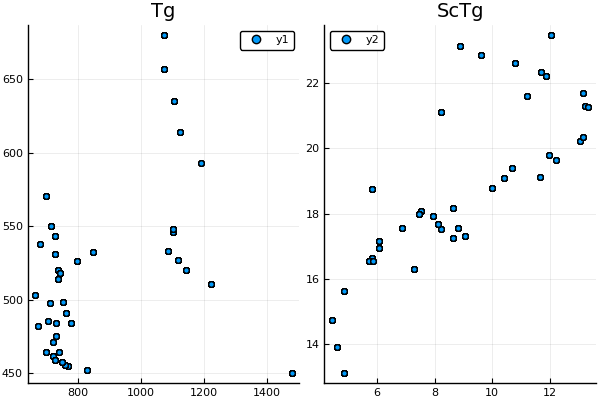

In [6]:
testmode!(m1)
testmode!(mr)

scatter(([X_entropy_tv[12,:],X_entropy_tv[11,:]],
        [tg(X_entropy_tv).data[:],ScTg(X_entropy_tv).data[:]]),layout=2, 
    title=["Tg" "ScTg"])


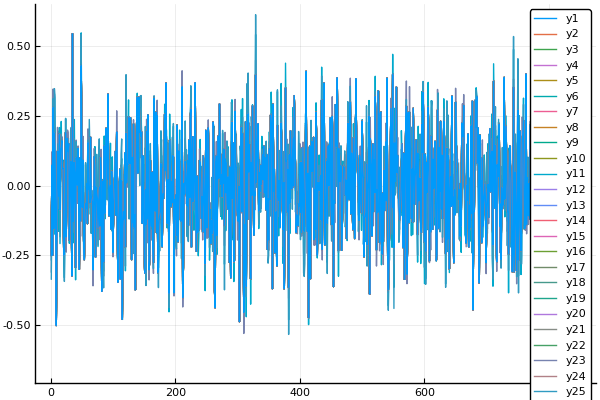

In [7]:
plot(mr(X_raman_train).data[:,:])

# Pre-train on Raman

In [10]:
nb_neurons_r = 5
nb_neurons_t = 5
p_drop = 0.5

nb_channels_raman = size(y_raman_train,1)

c1 = Dense(4, nb_neurons_r, tanh)
c2 = Dense(nb_neurons_r, nb_neurons_t, tanh)

cout_raman =  Dense(nb_neurons_r,nb_channels_raman)

mr = Chain(
        c1, #Dropout(p_drop),
        #c2, Dropout(p_drop),
        cout_raman)

loss_raman(x,raman_target) = mse(mr(x),raman_target) + L2_norm*sum(norm, params(mr))

L2_norm = 0.001
loss_raman(X_raman_train,y_raman_train)

12.403982062741797 (tracked)

# Nb neurons

No dropout, L2_norm = 0.001, tanh activations

In [24]:
L2_norm = 0.001

nb_neurons_r = [80] # tested neurons numbers
nb_test = size(nb_neurons_r,1)

results_loss_train = ones(nb_test)
results_loss_valid = ones(nb_test)

nb_epoch = 2000 # number of epoch

for j = 1:nb_test
    
    loss_train_rec = ones(5)
    loss_valid_rec = ones(5)
    
    for i = 1:5
        c1 = Dense(4, nb_neurons_r[j], tanh)
        c2 = Dense(nb_neurons_r[j], nb_neurons_r[j], tanh)

        cout_raman =  Dense(nb_neurons_r[j],nb_channels_raman)

        mr = Chain(c1,cout_raman)

        # SC training
        record_loss_raman_train = Float64[]
        record_loss_raman_valid = Float64[]

        testmode!(mr,false)

        epoch_idx = 1; 

        dataset_raman = [(X_raman_train,y_raman_train)]

        while epoch_idx < nb_epoch

            evalcb = () -> (push!(record_loss_raman_train, loss_raman(X_raman_train, y_raman_train).data),
                            push!(record_loss_raman_valid, loss_raman(X_raman_valid, y_raman_valid).data))
            Flux.train!(loss_raman, params(mr), dataset_raman, ADAM(0.001), cb = throttle(evalcb, 1))

            epoch_idx += 1
        end
        
        loss_train_rec[i] = mean(record_loss_raman_train[end-20:end])
        loss_valid_rec[i] = mean(record_loss_raman_valid[end-20:end])
        
    end
    results_loss_train[j] = mean(loss_train_rec)
    results_loss_valid[j] = mean(loss_valid_rec)
    print("\nWith $(nb_neurons_r[j]), train error is $(loss_train_rec[j])\n")
    print("\nWith $(nb_neurons_r[j]), valid error is $(loss_valid_rec[j])\n")
    
end



With 80, train error is 2.2734929946584037

With 80, valid error is 2.9129936694056893


# L2_norm test

In [19]:
L2_norm_list = [0.1,0.01,0.001,0.0001,0.000001]

nb_test = size(L2_norm_list,1)

results_loss_train = ones(5)
results_loss_valid = ones(5)

nb_neurons_r = 20 # tested neurons numbers

nb_epoch = 2000 # number of epoch

for j = 5
    L2_norm = L2_norm_list[j]
    
    loss_train_rec = ones(5)
    loss_valid_rec = ones(5)
    
    for i = 1:5
        c1 = Dense(4, nb_neurons_r, tanh)
        c2 = Dense(nb_neurons_r, nb_neurons_r, tanh)

        cout_raman =  Dense(nb_neurons_r,nb_channels_raman)

        mr = Chain(c1,cout_raman)

        # SC training
        record_loss_raman_train = Float64[]
        record_loss_raman_valid = Float64[]

        testmode!(mr,false)

        epoch_idx = 1; 

        dataset_raman = [(X_raman_train,y_raman_train)]

        while epoch_idx < nb_epoch

            evalcb = () -> (push!(record_loss_raman_train, loss_raman(X_raman_train, y_raman_train).data),
                            push!(record_loss_raman_valid, loss_raman(X_raman_valid, y_raman_valid).data))
            Flux.train!(loss_raman, params(mr), dataset_raman, ADAM(0.001), cb = throttle(evalcb, 1))

            epoch_idx += 1
        end
        
        loss_train_rec[i] = mean(record_loss_raman_train[end-20:end])
        loss_valid_rec[i] = mean(record_loss_raman_valid[end-20:end])
        
    end
    results_loss_train[j] = mean(loss_train_rec)
    results_loss_valid[j] = mean(loss_valid_rec)
    print("\nWith L2 norm = $(L2_norm_list[j]), train error is $(loss_train_rec[j])\n")
    print("\nWith L2 norm = $(L2_norm_list[j]), valid error is $(loss_valid_rec[j])\n")
    
end



With L2 norm = 1.0e-6, train error is 2.100820041029607

With L2 norm = 1.0e-6, valid error is 2.628747462417779


# p_drop test

In [25]:
# tested variable
p_drop_list = [0.2,0.3,0.4,0.5]

nb_test = size(p_drop_list,1)

L2_norm = 0.0

results_loss_train = ones(nb_test)
results_loss_valid = ones(nb_test)

nb_neurons_r = 40 # tested neurons numbers

nb_epoch = 2000 # number of epoch

for j = 1:nb_test
    p_drop = p_drop_list[j]
    
    loss_train_rec = ones(5)
    loss_valid_rec = ones(5)
    
    for i = 1:5
        c1 = Dense(4, nb_neurons_r, tanh)
        c2 = Dense(nb_neurons_r, nb_neurons_r, tanh)

        cout_raman =  Dense(nb_neurons_r,nb_channels_raman)

        mr = Chain(c1,Dropout(p_drop),cout_raman)

        # SC training
        record_loss_raman_train = Float64[]
        record_loss_raman_valid = Float64[]

        testmode!(mr,false)

        epoch_idx = 1; 

        dataset_raman = [(X_raman_train,y_raman_train)]

        while epoch_idx < nb_epoch

            evalcb = () -> (push!(record_loss_raman_train, loss_raman(X_raman_train, y_raman_train).data),
                            push!(record_loss_raman_valid, loss_raman(X_raman_valid, y_raman_valid).data))
            Flux.train!(loss_raman, params(mr), dataset_raman, ADAM(0.001), cb = throttle(evalcb, 1))

            epoch_idx += 1
        end
        
        loss_train_rec[i] = mean(record_loss_raman_train[end-20:end])
        loss_valid_rec[i] = mean(record_loss_raman_valid[end-20:end])
        
    end
    results_loss_train[j] = mean(loss_train_rec)
    results_loss_valid[j] = mean(loss_valid_rec)
    print("\nWith p_drop = $(p_drop_list[j]), train error is $(loss_train_rec[j])\n")
    print("\nWith p_drop = $(p_drop_list[j]), valid error is $(loss_valid_rec[j])\n")
    
end



With p_drop = 0.2, train error is 1.9703130494980585

With p_drop = 0.2, valid error is 2.602755864461263

With p_drop = 0.3, train error is 2.138252542132423

With p_drop = 0.3, valid error is 2.606920355842227

With p_drop = 0.4, train error is 2.5111469541277205

With p_drop = 0.4, valid error is 2.8108908108302524

With p_drop = 0.5, train error is 2.5515011492229642

With p_drop = 0.5, valid error is 2.8272757870810374


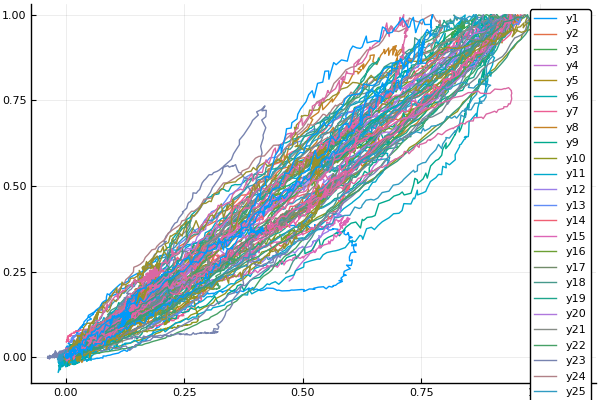

In [218]:
testmode!(mr)
plot(mr(X_raman_train).data[:,:],y_raman_train)

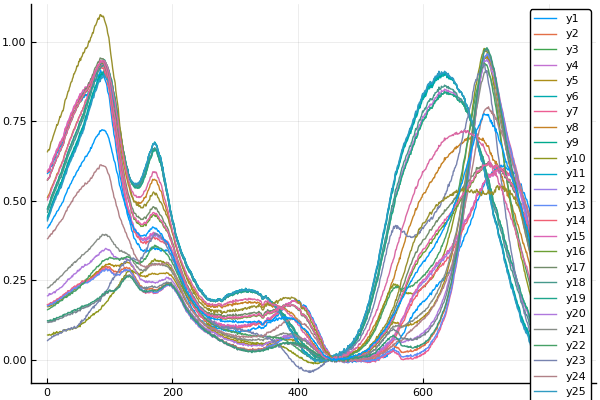

In [219]:
plot(mr(X_raman_train).data[:,:])

# Pre-train on only entropy + Tg

In [67]:
# SC training

# loss function
loss_tg_sc(x,tg_target,sc_target) = loss_tg(x,tg_target) .+ loss_sc(x,sc_target).*100.0 + L2_norm*sum(norm, params(mr))# Add this to your loss

L2_norm = 0.0001

# record loss
record_loss_sc_train = Float64[]
record_loss_sc_valid = Float64[]
record_loss_sc_tv = Float64[]

record_folds_train = Float64[]
record_folds_valid = Float64[]

# unfreeze dropout
testmode!(m1,false)
testmode!(mr,false)

# loop details
epoch_idx = 1; optimal_epochs_s = 0; 
early_stop = 1; patience = 100
min_loss_val = 30000000.0

# loop
p = ProgressMeter.Progress(patience, 1)   # minimum update interval: 1 second
while early_stop < patience

    for j =1:nb_folds

        train,valid = folds_entropy[j]
        x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(train[1],train[2])
        x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(valid[1],valid[2])

        evalcb = () -> (push!(record_folds_train, loss_tg_sc(x_train_, tg_train_, sc_train_).data),
            push!(record_folds_valid, loss_tg_sc(x_valid_, tg_valid_, sc_valid_).data))
        
        Flux.train!(loss_tg_sc, params(c2,cout_thermo), [(x_train_, tg_train_, sc_train_)], ADAM(0.001), cb = throttle(evalcb, 1))

    end

    push!(record_loss_sc_train, 1.0./convert(Float64,nb_folds).*sum(record_folds_train))
    push!(record_loss_sc_valid, 1.0./convert(Float64,nb_folds).*sum(record_folds_valid))

    record_folds_train = Float64[]
    record_folds_valid = Float64[]

    ProgressMeter.update!(p, early_stop)

    # Early stopping criterion
    if record_loss_sc_valid[epoch_idx] < min_loss_val
        early_stop = 0
        optimal_epochs = epoch_idx
        min_loss_val = record_loss_sc_valid[epoch_idx]
    else
        early_stop += 1
    end
    epoch_idx += 1
end


Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:02

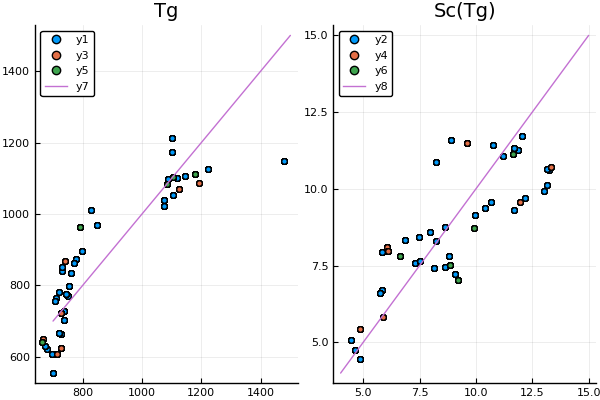

In [68]:
testmode!(m1)
testmode!(mr)

scatter([X_entropy_train[12,:],X_entropy_train[11,:]],
    [tg(X_entropy_train).data[:],ScTg(X_entropy_train).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_valid[12,:],X_entropy_valid[11,:]],
    [tg(X_entropy_valid).data[:],ScTg(X_entropy_valid).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_test[12,:],X_entropy_test[11,:]],
    [tg(X_entropy_test).data[:],ScTg(X_entropy_test).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

plot!([[700;1500] [4;15]],[[700;1500] [4;15]])

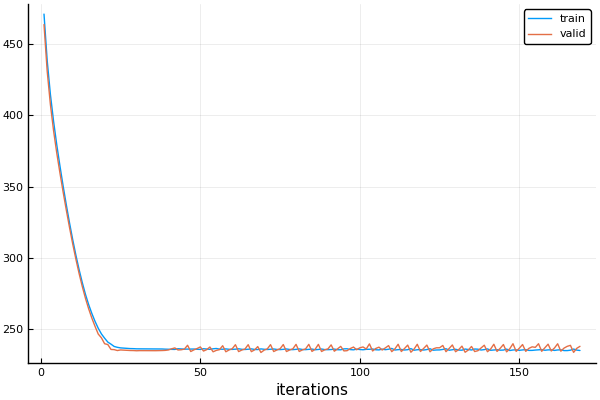

In [69]:
testmode!(m1)
testmode!(mr)
# Plot
plot([record_loss_sc_train],label="train",xlabel="iterations")
plot!(record_loss_sc_valid,label="valid")

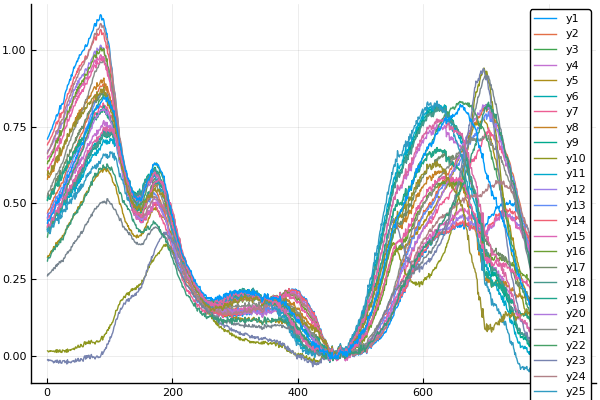

In [41]:
plot(mr(X_raman_train).data[:,:])

# Train on loss global : entropy + viscosity

In [226]:
x_train_, y_train_, T_train_, ap_train_, b_train_, sc_train_, tg_train_ = prepare_datas(X_train,y_train)
x_valid_, y_valid_, T_valid_, ap_valid_, b_valid_, sc_valid_, tg_valid_ = prepare_datas(X_valid,y_valid)

x_entro_train_, y_entro_train_, T_entro_train_, ap_entro_train_, b_entro_train_, sc_entro_train_, tg_entro_train_ = prepare_datas(X_entropy_train,X_entropy_train[11,:])
x_entro_valid_, y_entro_valid_, T_entro_valid_, ap_entro_valid_, b_entro_valid_, sc_entro_valid_, tg_entro_valid_ = prepare_datas(X_entropy_valid,X_entropy_valid[11,:])

print("\nloss Raman: $(loss_raman(X_raman_train, y_raman_train))")
print("\nloss tg: $(loss_tg(x_entro_train_, tg_entro_train_))")
print("\nloss sc: $(loss_sc(x_entro_train_, sc_entro_train_))")
print("\nloss n train: $(loss_n(x_train_, T_train_ ,ap_train_, b_train_, y_train_))")

L2_norm = 0.01
loss_global(x, T, ap, b, y_target, x2, tg2_target, sc2_target, x_raman, y_raman) = 
    loss_n(x, T, ap, b, y_target) .+ 
    0.01.*loss_tg(x2,tg2_target) .+ 
    loss_sc(x2,sc2_target) .+
    0.01.*loss_raman(x_raman, y_raman) .+
    L2_norm*sum(norm, params(m1))



loss Raman: 1.5143240473687898 (tracked)
loss tg: 48.63793852630685 (tracked)
loss sc: 1.0122749925793257 (tracked)
loss n train: 0.8687574815244148 (tracked)

loss_global (generic function with 1 method)

In [227]:
record_loss_train = Float64[]
record_loss_valid = Float64[]
    
testmode!(m1,false)

epoch_idx = 1; optimal_epochs_s = 0; 
early_stop = 1; patience = 500
min_loss_val = 30000000.0; max_epoch = 1000

p = ProgressMeter.Progress(max_epoch, 1)   # minimum update interval: 1 second

dataset = [(x_train_, T_train_ ,ap_train_, b_train_, y_train_,
                x_entro_train_, tg_entro_train_, sc_entro_train_,X_raman_train, y_raman_train)]

while epoch_idx < max_epoch
#while early_stop < patience
    
    evalcb = () -> (push!(record_loss_train, loss_global(x_train_, T_train_ ,ap_train_, b_train_, y_train_,
                x_entro_train_, tg_entro_train_, sc_entro_train_,X_raman_train, y_raman_train).data),
                push!(record_loss_valid, loss_global(x_valid_, T_valid_ ,ap_valid_, b_valid_, y_valid_,
                x_entro_valid_, tg_entro_valid_, sc_entro_valid_,X_raman_valid, y_raman_valid).data))
    Flux.train!(loss_global, params(Ae,m1,mr), dataset, ADAM(0.001), cb = throttle(evalcb, 1))

    ProgressMeter.update!(p, epoch_idx)

    # Early stopping criterion
    if record_loss_valid[epoch_idx] < min_loss_val
        early_stop = 0
        optimal_epochs = epoch_idx
        min_loss_val = record_loss_valid[epoch_idx]
        @save "./model/m1.bson" m1
        @save "./model/Ae.bson" Ae
    else
        early_stop += 1
    end
    epoch_idx += 1
    
end

Progress:  98%|████████████████████████████████████████▍|  ETA: 0:00:01

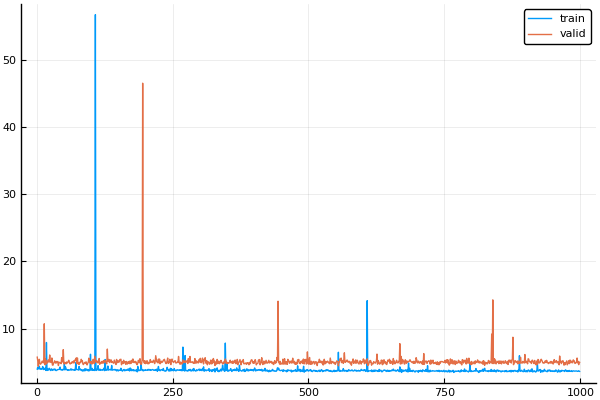

In [228]:
testmode!(m1)
#println("Optimal number of epochs:", optimal_epochs)
#println("Min loss val:", min_loss_val)
# Plot
plot([record_loss_train],layout=1,label="train")
plot!(record_loss_valid,label="valid")

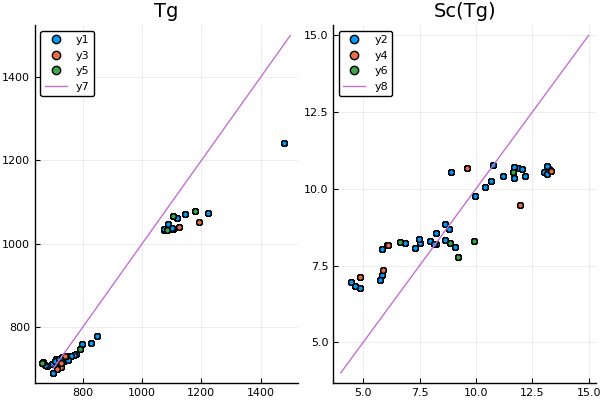

In [229]:
testmode!(m1)
scatter([X_entropy_train[12,:],X_entropy_train[11,:]],
    [tg(X_entropy_train).data[:],ScTg(X_entropy_train).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_valid[12,:],X_entropy_valid[11,:]],
    [tg(X_entropy_valid).data[:],ScTg(X_entropy_valid).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

scatter!([X_entropy_test[12,:],X_entropy_test[11,:]],
    [tg(X_entropy_test).data[:],ScTg(X_entropy_test).data[:]],
    layout=2, title=["Tg" "Sc(Tg)"])

plot!([[700;1500] [4;15]],[[700;1500] [4;15]])

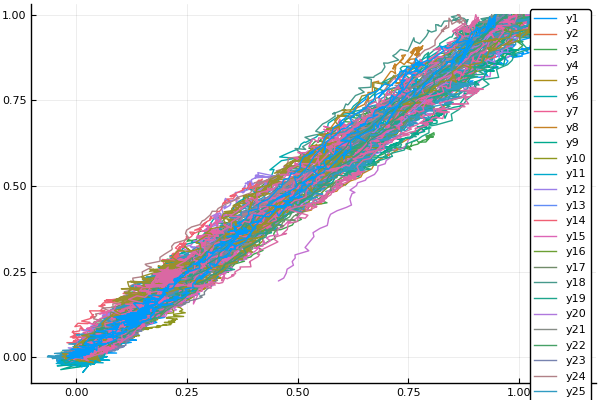

In [195]:
plot(mr(X_raman_train).data[:,:],y_raman_train)

In [196]:
scatter(y_train_[:],
    model(x_train_,T_train_,ap_train_, b_train_).data[:],)
scatter!(y_valid_[:],
    model(x_valid_,T_valid_,ap_valid_, b_valid_).data[:],)
plot!([0.,16.],[0.,16.],ylim=(0,16))

print("\nloss n train: $(loss_n(x_train_, T_train_ ,ap_train_, b_train_, y_train_))")
print("\nloss n valid: $(loss_n(x_valid_, T_valid_ ,ap_valid_, b_valid_, y_valid_))")



loss n train: 0.9473190196380425 (tracked)
loss n valid: 1.351887154088569 (tracked)

In [355]:
@save "./model/m1.bson" m1
@save "./model/Ae.bson" Ae

# Visualizing

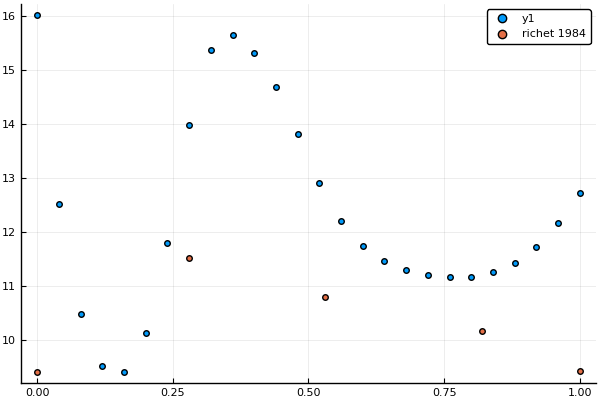

In [353]:
na2o = collect(0.:0.01:0.25)
k2o = 0.25.-na2o
sio2 = ones(size(na2o,1)).*0.75
al2o3 = zeros(size(na2o,1))
dummy = zeros(size(na2o,1))
T = ones(size(na2o,1)).*1000.0

X_visu_NKS = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

X_visu_NKS_sc = copy(X_visu_NKS)

for i = 1:7
    X_visu_NKS_sc[i,:] = (X_visu_NKS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
end


scatter(X_visu_NKS[4,:]./(X_visu_NKS[3,:].+X_visu_NKS[4,:]),ScTg(X_visu_NKS_sc).data'[:])
scatter!([0,0.28,0.53,0.82,1.0],[32.91,40.31,37.81,35.59,32.99]./7.0.*2.0,label="richet 1984")

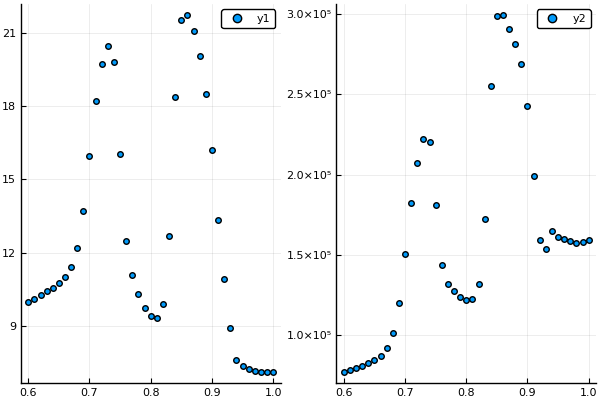

In [354]:
sio2 = collect(0.6:0.01:1.)
al2o3 = zeros(size(sio2,1))
na2o = 1.0.-sio2
k2o = zeros(size(sio2,1))
dummy = zeros(size(sio2,1))
T = ones(size(sio2,1)).*1000.0
X_visu_NS = [sio2 al2o3 na2o k2o dummy dummy dummy dummy dummy T dummy dummy]'

X_visu_NS_sc = copy(X_visu_NS)

for i = 1:7
    X_visu_NS_sc[i,:] = (X_visu_NS_sc[i,:].- X_scaler_mean[i])./sqrt.(X_scaler_var[i]) 
end
#x_visu_xaxis = X_visu_NKS[4,:]
#./(X_visu_NKS[3,:].+X_visu_NKS[4,:])'

scatter([X_visu_NS[1,:],X_visu_NS[1,:]],
    [ScTg(X_visu_NS_sc).data'[:],Be(X_visu_NS_sc).data'[:]],
layout=2)
